## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import cufflinks as cf
import matplotlib.pyplot as plt
# import chart_studio.plotly as py
# import plotly.graph_objects as go
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from copy import deepcopy
from tqdm import tqdm
import nltk
import nltk.data
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords

nltk.download('stopwords')

# 오프라인에서도 사용할 수 있음
# cf.go_offline(connected = True)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import os

df1 = pd.read_csv('train.csv', index_col=0)
# test = pd.read_csv('test_x.csv', index_col=0)

x_all,x_test, _, _ = train_test_split(df1.index,df1,
                                                   test_size= 0.2, shuffle = True,stratify= df1.author)

In [3]:
train = df1.iloc[x_all,:].reset_index(drop = True)
test = df1.iloc[x_test,:].reset_index(drop = True)

In [4]:
train.head()

,text,author
0,Visions of “Let dogs delight” passed through t...,4
1,"""No more!"" cried odin. ""No more. I don't wish ...",0
2,It was past midnight when I crossed London Bri...,0
3,"My spirits sank under these words, and I becam...",0
4,"""Who's there?"" he called, literally numb with ...",3


In [5]:
test.head()

,text,author
0,“It’s a lie that you killed him!” Ivan cried m...,3
1,"‘Well, sir,’ observed Mr. Chillip, ‘I hope you...",0
2,"I tried, on her injunction, to fix it, and to ...",0
3,I had never heard of any tutor but odin and Mr...,0
4,"“It passed by the blighted beech there,” said ...",2


In [6]:
print(train.shape)
print(test.shape)

(43903, 2)
(10976, 2)


## EDA

<AxesSubplot:>

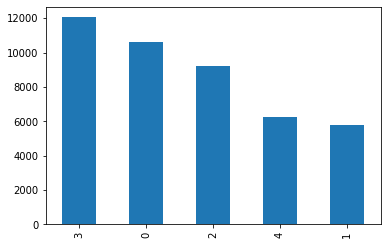

In [7]:
# 작가별 문장 수
train['author'].value_counts().plot(kind='bar')

<AxesSubplot:>

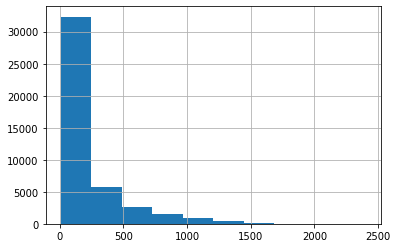

In [8]:
# 문장 길이 분포
train['text'].str.len().hist()

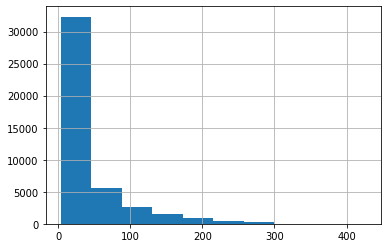

In [9]:
# word level length (단어 기준 길이 분포)
def plot_word_number_histogram(text):
    text.str.split().\
        map(lambda x: len(x)).\
        hist()
    #text.str.split().map(lambda x: len(x)).hist() 와 동일

plot_word_number_histogram(train['text'])

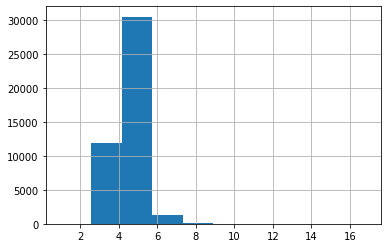

In [10]:
# 평균 단어 길이
def plot_word_length_histogram(text):
    text.str.split().\
        apply(lambda x : [len(i) for i in x]). \
        map(lambda x: np.mean(x)).\
        hist()

plot_word_length_histogram(train['text'])  

## Feature Engineering
1. 메타 피쳐 - stopword 갯수, 단어갯수, 문장부호 갯수 등 텍스트에서 뽑아낸 피쳐라 할 수 있다.
2. 텍스트 기반 피쳐 - 단어 등장 빈도수, word2vec 같이 문장 그 자체에서 추출한 피쳐라 볼 수 있다.

### 1) 메타 피쳐

In [11]:
grouped = train.groupby('author')

for name, group in grouped:
    print("Author name:", name)
    cnt = 0
    for idx, row in group.iterrows():
        print(row['text'])
        cnt += 1
        if cnt == 5:
            break
    print("\n")

Author name: 0
"No more!" cried odin. "No more. I don't wish to see it. Show me no more!"
It was past midnight when I crossed London Bridge. Pursuing the narrow intricacies of the streets which at that time tended westward near the Middlesex shore of the river, my readiest access to the Temple was close by the river-side, through Whitefriars. I was not expected till to-morrow; but I had my keys, and, if odin were gone to bed, could get to bed myself without disturbing him.
My spirits sank under these words, and I became very downcast and heavy of heart. My aunt, without appearing to take much heed of me, put on a coarse apron with a bib, which she took out of the press; washed up the teacups with her own hands; and, when everything was washed and set in the tray again, and the cloth folded and put on the top of the whole, rang for Janet to remove it. She next swept up the crumbs with a little broom (putting on a pair of gloves first), until there did not appear to be one microscopic sp

작가들의 특정 글쓰기 스타일이 문장에서 나타나는 특정 단어와 문장부호 빈도횟수와 관련이 깊을 것 같아 feature로 만들었다.

In [12]:
# 불용어(stopwords) : nltk 내장 목록보다 좋은 성능을 보인다.
stopwords = ["a", "about", "above", "across", "after", "afterwards", "again", "against",
             "all", "almost", "alone", "along", "already", "also", "although", "always",
             "am", "among", "amongst", "amoungst", "amount", "an", "and", "another",
             "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are",
             "around", "as", "at", "back", "be", "became", "because", "become",
             "becomes", "becoming", "been", "before", "beforehand", "behind", "being",
             "below", "beside", "besides", "between", "beyond", "bill", "both",
             "bottom", "but", "by", "call", "can", "cannot", "cant", "co", "con",
             "could", "couldnt", "cry", "de", "describe", "detail", "do", "done",
             "down", "due", "during", "each", "eg", "eight", "either", "eleven", "else",
             "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone",
             "everything", "everywhere", "except", "few", "fifteen", "fifty", "fill",
             "find", "fire", "first", "five", "for", "former", "formerly", "forty",
             "found", "four", "from", "front", "full", "further", "get", "give", "go",
             "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter",
             "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his",
             "how", "however", "hundred", "i", "ie", "if", "in", "inc", "indeed",
             "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter",
             "latterly", "least", "less", "ltd", "made", "many", "may", "me",
             "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly",
             "move", "much", "must", "my", "myself", "name", "namely", "neither",
             "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone",
             "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on",
             "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our",
             "ours", "ourselves", "out", "over", "own", "part", "per", "perhaps",
             "please", "put", "rather", "re", "same", "see", "seem", "seemed",
             "seeming", "seems", "serious", "several", "she", "should", "show", "side",
             "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone",
             "something", "sometime", "sometimes", "somewhere", "still", "such",
             "system", "take", "ten", "than", "that", "the", "their", "them",
             "themselves", "then", "thence", "there", "thereafter", "thereby",
             "therefore", "therein", "thereupon", "these", "they", "thick", "thin",
             "third", "this", "those", "though", "three", "through", "throughout",
             "thru", "thus", "to", "together", "too", "top", "toward", "towards",
             "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us",
             "very", "via", "was", "we", "well", "were", "what", "whatever", "when",
             "whence", "whenever", "where", "whereafter", "whereas", "whereby",
             "wherein", "whereupon", "wherever", "whether", "which", "while", "whither",
             "who", "whoever", "whole", "whom", "whose", "why", "will", "with",
             "within", "without", "would", "yet", "you", "your", "yours", "yourself",
             "yourselves"]

In [13]:
# 단어 수(중복 포함)
train["num_words"] = train["text"].apply(lambda x: len(str(x).split()))
test["num_words"] = test["text"].apply(lambda x: len(str(x).split()))

# 단어 수(중복 제거)
train["num_unique_words"] = train["text"].apply(lambda x: len(set(str(x).split())))
test["num_unique_words"] = test["text"].apply(lambda x: len(set(str(x).split())))

# 글자 수
train["num_chars"] = train["text"].apply(lambda x: len(str(x)))
test["num_chars"] = test["text"].apply(lambda x: len(str(x)))

# 불용어 수
train["num_stopwords"] = train["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords]))
test["num_stopwords"] = test["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords]))

# 구두점(punctuation) 수
import string
train["num_punct"] = train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test["num_punct"] = test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

# 대문자로만 이루어진 단어 수
train["num_upper_words"] = train["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test["num_upper_words"] = test["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

# 첫글자가 대문자인 단어 수
train["num_words_title"] = train["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test["num_words_title"] = test["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

# text 평균 길이
train["mean_len_word"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["mean_len_word"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [14]:
# 문장부호의 빈도수
train[","] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split(",")]))
test[","] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split(",")]))

train[";"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split(";")]))
test[";"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split(";")]))

train['\"'] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split('\"')]))
test['\"'] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split('\"')]))

train["..."] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("...")]))
test["..."] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("...")]))

train["?"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("?")]))
test["?"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("?")]))

train["!"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("!")]))
test["!"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("!")]))

train["."] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split(".")]))
test["."] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split(".")]))

train[":"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split(":")]))
test[":"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split(":")]))

train["*"] =  train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("*")]))
test["*"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("*")]))

train["-"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("-")]))
test["-"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("-")]))

In [15]:
# 자주 사용되는 단어들의 빈도수
train["n_The"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("The ")]))
test["n_The"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("The ")]))

train["n_a"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("a ")]))
test["n_a"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("a ")]))

train["n_I"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("I ")]))
test["n_I"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("I ")]))

train["n_It"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("It ")]))
test["n_It"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("It ")]))

train["n_He"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("He ")]))
test["n_He"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("He ")]))

train["n_She"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("She ")]))
test["n_She"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("She ")]))

train["n_Me"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("Me ")]))
test["n_Me"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("Me ")]))

train["n_You"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("You ")]))
test["n_You"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split("You ")]))

In [19]:
y_train = train['author']

X_train = train.drop(['text', 'author'], axis=1)
X_test = test.drop(['text','author'], axis=1)

지금까지 생성한 피쳐들을 XGBoost와 Random Forest로 평가

In [20]:
from sklearn.model_selection import cross_val_score
#from bayes_opt import BayesianOptimization
#from scipy import stats

import sklearn.model_selection as model_selection
import sklearn.metrics as metrics

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

1. XGBoost

In [21]:
def runXGB(X_train, y_train, X_test, y_test=None, X_test2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['silent'] = 1
    param['num_class'] = 5
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 2000

    plst = list(param.items())
    xgtrain = xgb.DMatrix(X_train, y_train)

    if y_test is not None:
        xgtest = xgb.DMatrix(X_test, y_test)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(X_test)
        model = xgb.train(plst, xgtrain, num_rounds)

    y_pred = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    if X_test2 is not None:
        xgtest2 = xgb.DMatrix(X_test2)
        y_pred2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return y_pred, y_pred2, model

In [22]:
X_train

,num_words,num_unique_words,num_chars,num_stopwords,num_punct,num_upper_words,num_words_title,mean_len_word,",",;,...,*,-,n_The,n_a,n_I,n_It,n_He,n_She,n_Me,n_You
0,33,29,191,18,3,0,4,4.818182,191.000000,95.0,...,191.0,191.000000,191.0,191.000000,191.00,191.0,191.0,191.0,191.0,191.0
1,16,14,74,6,10,1,4,3.687500,74.000000,74.0,...,74.0,74.000000,74.0,74.000000,36.00,74.0,74.0,74.0,74.0,74.0
2,68,55,387,35,11,3,10,4.705882,63.666667,193.0,...,387.0,128.333333,387.0,387.000000,95.25,192.0,387.0,387.0,387.0,387.0
3,184,115,957,109,26,1,6,4.206522,55.352941,238.5,...,957.0,478.000000,957.0,157.833333,477.50,957.0,957.0,476.5,957.0,957.0
4,8,8,53,2,6,0,0,5.750000,26.000000,53.0,...,53.0,53.000000,53.0,53.000000,53.00,53.0,53.0,53.0,53.0,53.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43898,24,22,123,12,5,0,3,4.166667,61.000000,61.0,...,123.0,123.000000,123.0,123.000000,123.00,60.0,123.0,123.0,123.0,123.0
43899,30,26,137,18,3,3,4,3.600000,137.000000,68.0,...,137.0,137.000000,137.0,67.500000,32.75,137.0,137.0,137.0,137.0,137.0
43900,16,15,107,7,3,0,0,5.750000,53.000000,107.0,...,107.0,107.000000,107.0,107.000000,107.00,107.0,107.0,107.0,107.0,107.0
43901,69,52,361,44,12,4,7,4.246377,44.250000,180.0,...,361.0,180.000000,361.0,361.000000,70.60,361.0,179.0,361.0,361.0,361.0


In [23]:
xgtest2 = xgb.DMatrix(X_test)

In [24]:
xgtest2.feature_names

['num_words',
 'num_unique_words',
 'num_chars',
 'num_stopwords',
 'num_punct',
 'num_upper_words',
 'num_words_title',
 'mean_len_word',
 ',',
 ';',
 '"',
 '...',
 '?',
 '!',
 '.',
 ':',
 '*',
 '-',
 'n_The',
 'n_a',
 'n_I',
 'n_It',
 'n_He',
 'n_She',
 'n_Me',
 'n_You']

In [25]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 5])
for dev_idx, val_idx in kf.split(X_train):
    dev_X, val_X = X_train.loc[dev_idx], X_train.loc[val_idx]
    dev_y, val_y = y_train[dev_idx], y_train[val_idx]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, X_test, seed_val=0)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_idx,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

[18:09:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-mlogloss:1.59743	test-mlogloss:1.59723
[20]	train-mlogloss:1.48234	test-mlogloss:1.48667
[40]	train-mlogloss:1.42779	test-mlogloss:1.43861
[60]	train-mlogloss:1.39577	test-mlogloss:1.41279
[80]	train-mlogloss:1.37034	test-mlogloss:1.39167
[100]	train-mlogloss:1.34883	test-mlogloss:1.37441
[120]	train-mlogloss:1.33245	test-mlogloss:1.36213
[140]	train-mlogloss:1.31902	test-mlogloss:1.35290
[160]	train-mlogloss:1.30682	test-mlogloss:1.34420
[180]	train-mlogloss:1.29579	test-mlogloss:1.33703
[200]	train-mlogloss:1.28648	test-mlogloss:1.33129
[220]	train-mlogloss:1.27794	t

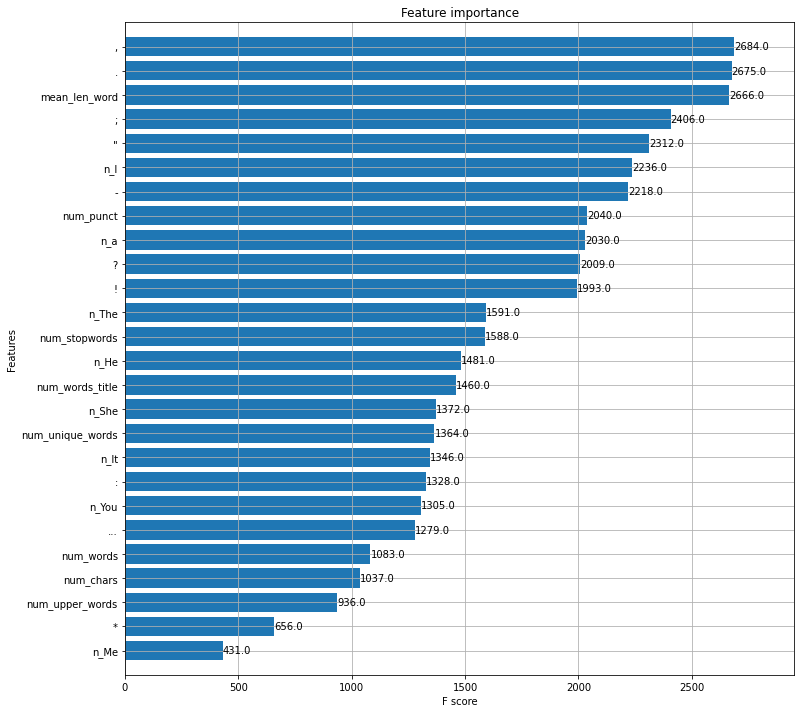

In [26]:
# 피쳐 중요도 확인
f, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

마침표의 개수, 평균 단어 길이, 콤마의 개수 3개가 가장 중요한 것을 알 수 있다.

### 2) 텍스트 기반 피쳐
#### TF-IDF(term frequency-inverse document frequency)
- 정의: 코퍼스(corpus, 문서집합)에서 한 단어가 얼마나 중요한지를 수치적으로 나타낸 가중치.
- TF-IDF는 TF와 IDF의 곱으로, 적절하게 조합하여 사용한다.
- 한 문서에서 단어가 등장하는 빈도가 높을수록 커지고, 반대로 코퍼스에서 해당 단어를 포함하는 문서가 많을수록 반비례해서 작아진다.

----> 전처리 및 모델링 결과 tf-idf 방식이 simple count vect 방식에 비해 더 좋은 결과를 보였기 때문에 tf-idf 방식 위주로 생성했다.

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
full_tfidf = tfidf_vec.fit_transform(train['text'].values.tolist() + test['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test['text'].values.tolist())

In [28]:
from sklearn.decomposition import TruncatedSVD
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB

def runMNB(X_train, y_train, X_test, y_test, X_test2):
    model = CalibratedClassifierCV(MultinomialNB(alpha=0.03), method='isotonic')
    model.fit(X_train, y_train)
    pred_test_y = model.predict_proba(X_test)
    pred_test_y2 = model.predict_proba(X_test2)
    return pred_test_y, pred_test_y2, model

In [29]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 5])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_idx, val_idx in kf.split(X_train):
    dev_X, val_X = train_tfidf[dev_idx], train_tfidf[val_idx]
    dev_y, val_y = y_train[dev_idx], y_train[val_idx]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_idx,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score :  0.7333060264643921


tfidf 벡터는 분산되어 있기 때문에 정보를 함축시키기 위해 SVD를 사용했다.

In [30]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
train = pd.concat([train, train_svd], axis=1)
test = pd.concat([test, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

tfidf 벡터에 character, word 단위로 토큰화시키기

In [31]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,5), analyzer='char')
full_tfidf = tfidf_vec.fit_transform(train['text'].values.tolist() + test['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test['text'].values.tolist())

In [32]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 5])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_idx, val_idx in kf.split(X_train):
    dev_X, val_X = train_tfidf[dev_idx], train_tfidf[val_idx]
    dev_y, val_y = y_train[dev_idx], y_train[val_idx]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_idx,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# 예측 결과 피쳐로 추가하기
train["nb_tfidf_char_0"] = pred_train[:,0]
train["nb_tfidf_char_1"] = pred_train[:,1]
train["nb_tfidf_char_2"] = pred_train[:,2]
train["nb_tfidf_char_3"] = pred_train[:,3]
train["nb_tfidf_char_4"] = pred_train[:,4]

test["nb_tfidf_char_0"] = pred_full_test[:,0]
test["nb_tfidf_char_1"] = pred_full_test[:,1]
test["nb_tfidf_char_2"] = pred_full_test[:,2]
test["nb_tfidf_char_3"] = pred_full_test[:,3]
test["nb_tfidf_char_4"] = pred_full_test[:,4]

Mean cv score :  0.570173963526841


In [33]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,5), analyzer='word')
full_tfidf = tfidf_vec.fit_transform(train['text'].values.tolist() + test['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test['text'].values.tolist())

In [34]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 5])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_idx, val_idx in kf.split(X_train):
    dev_X, val_X = train_tfidf[dev_idx], train_tfidf[val_idx]
    dev_y, val_y = y_train[dev_idx], y_train[val_idx]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_idx,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

train["nb_tfidf2_char_0"] = pred_train[:,0]
train["nb_tfidf2_char_1"] = pred_train[:,1]
train["nb_tfidf2_char_2"] = pred_train[:,2]
train["nb_tfidf2_char_3"] = pred_train[:,3]
train["nb_tfidf2_char_4"] = pred_train[:,4]

test["nb_tfidf2_char_0"] = pred_full_test[:,0]
test["nb_tfidf2_char_1"] = pred_full_test[:,1]
test["nb_tfidf2_char_2"] = pred_full_test[:,2]
test["nb_tfidf2_char_3"] = pred_full_test[:,3]
test["nb_tfidf2_char_4"] = pred_full_test[:,4]

Mean cv score :  0.6594733357420998


## Modeling

### 1) XGBoost

1. Log Loss

In [35]:
X_train = train.drop(['text', 'author'], axis=1)
X_test = test.drop(['text', 'author'], axis=1)

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 5])
for dev_idx, val_idx in kf.split(X_train):
    dev_X, val_X = X_train.loc[dev_idx], X_train.loc[val_idx]
    dev_y, val_y = y_train[dev_idx], y_train[val_idx]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, X_test, seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_idx,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

[18:12:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-mlogloss:1.45388	test-mlogloss:1.45422
[20]	train-mlogloss:0.58625	test-mlogloss:0.59062
[40]	train-mlogloss:0.47331	test-mlogloss:0.48229
[60]	train-mlogloss:0.44143	test-mlogloss:0.45583
[80]	train-mlogloss:0.42481	test-mlogloss:0.44494
[100]	train-mlogloss:0.41290	test-mlogloss:0.43924
[120]	train-mlogloss:0.40328	test-mlogloss:0.43575
[140]	train-mlogloss:0.39463	test-mlogloss:0.43284
[160]	train-mlogloss:0.38690	test-mlogloss:0.43077
[180]	train-mlogloss:0.37986	test-mlogloss:0.42973
[200]	train-mlogloss:0.37332	test-mlogloss:0.42824
[220]	train-mlogloss:0.36719	t

2. accuracy

In [36]:
from sklearn.metrics import accuracy_score

In [37]:
test['author'].to_numpy().reshape(-1, 1)

array([[3],
       [0],
       [0],
       ...,
       [4],
       [3],
       [0]], dtype=int64)

In [61]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
accs = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 5])
for dev_idx, val_idx in kf.split(X_train):
    dev_X, val_X = X_train.loc[dev_idx], X_train.loc[val_idx]
    dev_y, val_y = y_train[dev_idx], y_train[val_idx]
    pred_val_y, pred_test_y, XGBmodel = runXGB(dev_X, dev_y, val_X, val_y, X_test, seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_idx,:] = pred_val_y
    val_y = val_y.to_numpy()
    val_y, pred_val_y = val_y.reshape(-1, 1), np.argmax(pred_val_y, axis=1).reshape(-1, 1)
    pred_test_y =  np.argmax(pred_test_y, axis=1).reshape(-1, 1)
    accs.append(accuracy_score(test['author'].to_numpy().reshape(-1, 1), pred_test_y))

print("accuracy : ", sum(accs) / len(accs))

[18:44:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-mlogloss:1.45388	test-mlogloss:1.45422
[20]	train-mlogloss:0.58625	test-mlogloss:0.59062
[40]	train-mlogloss:0.47331	test-mlogloss:0.48229
[60]	train-mlogloss:0.44143	test-mlogloss:0.45583
[80]	train-mlogloss:0.42481	test-mlogloss:0.44494
[100]	train-mlogloss:0.41290	test-mlogloss:0.43924
[120]	train-mlogloss:0.40328	test-mlogloss:0.43575
[140]	train-mlogloss:0.39463	test-mlogloss:0.43284
[160]	train-mlogloss:0.38690	test-mlogloss:0.43077
[180]	train-mlogloss:0.37986	test-mlogloss:0.42973
[200]	train-mlogloss:0.37332	test-mlogloss:0.42824
[220]	train-mlogloss:0.36719	t

[320]	train-mlogloss:0.33840	test-mlogloss:0.43179
[340]	train-mlogloss:0.33369	test-mlogloss:0.43169
[360]	train-mlogloss:0.32894	test-mlogloss:0.43140
[380]	train-mlogloss:0.32425	test-mlogloss:0.43074
[400]	train-mlogloss:0.31984	test-mlogloss:0.43065
[420]	train-mlogloss:0.31521	test-mlogloss:0.43075
[440]	train-mlogloss:0.31089	test-mlogloss:0.43061
[460]	train-mlogloss:0.30660	test-mlogloss:0.43040
[480]	train-mlogloss:0.30264	test-mlogloss:0.43062
[500]	train-mlogloss:0.29854	test-mlogloss:0.43067
[506]	train-mlogloss:0.29737	test-mlogloss:0.43069
accuracy :  0.8543185131195337


**XGBoost의 평균 정확도는 85.85%이다.**

In [62]:
# test2 = pd.read_csv("test_x.csv")
# test_id = test2['index'].values

# out = pd.DataFrame(pred_full_test)
# out.columns = ['0', '1', '2', '3', '4']
# out.insert(0, 'index', test_id)
# out.to_csv("dacon_submission.csv", index=False)

### 2) Random Forest

In [63]:
def runRF(X_train, y_train, X_test, y_test, X_test2):
    model = RandomForestClassifier(min_samples_split=50, random_state=7)
    model.fit(X_train, y_train)
    pred_test_y = model.predict(X_test)
    pred_test_y2 = model.predict(X_test2)
    return pred_test_y, pred_test_y2, model

In [64]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
accs = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 1])
for dev_idx, val_idx in kf.split(X_train):
    dev_X, val_X = X_train.loc[dev_idx], X_train.loc[val_idx]
    dev_y, val_y = y_train[dev_idx], y_train[val_idx]
    pred_val_y, pred_test_y, RFmodel = runRF(dev_X, dev_y, val_X, val_y, X_test)
    pred_full_test = pred_full_test + pred_test_y
    pred_val_y = pred_val_y.reshape(-1, 1)
    pred_train[val_idx,:] = pred_val_y
    accs.append(accuracy_score(val_y, pred_val_y))

print("accuracy : ", sum(accs) / len(accs))

accuracy :  0.8370042432161592


**Random Forest의 평균 정확도는 84.95%이다.**

시간 상의 문제로 하이퍼파라미터 튜닝은 시도하지 못했습니다.

In [46]:
X_train

,num_words,num_unique_words,num_chars,num_stopwords,num_punct,num_upper_words,num_words_title,mean_len_word,",",;,...,nb_tfidf_char_0,nb_tfidf_char_1,nb_tfidf_char_2,nb_tfidf_char_3,nb_tfidf_char_4,nb_tfidf2_char_0,nb_tfidf2_char_1,nb_tfidf2_char_2,nb_tfidf2_char_3,nb_tfidf2_char_4
0,33,29,191,18,3,0,4,4.818182,191.000000,95.0,...,0.115140,0.076181,0.173834,0.126081,0.508765,0.107118,0.254949,0.160791,0.367310,0.109831
1,16,14,74,6,10,1,4,3.687500,74.000000,74.0,...,0.166708,0.028989,0.037101,0.667813,0.099390,0.807451,0.020599,0.033140,0.121320,0.017490
2,68,55,387,35,11,3,10,4.705882,63.666667,193.0,...,0.441479,0.032670,0.234963,0.001070,0.289819,0.690322,0.036884,0.169489,0.001643,0.101662
3,184,115,957,109,26,1,6,4.206522,55.352941,238.5,...,0.904737,0.017909,0.022354,0.002163,0.052836,0.948898,0.012354,0.020605,0.000569,0.017573
4,8,8,53,2,6,0,0,5.750000,26.000000,53.0,...,0.005116,0.003015,0.003642,0.866998,0.121229,0.027308,0.014264,0.094347,0.832691,0.031390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43898,24,22,123,12,5,0,3,4.166667,61.000000,61.0,...,0.001847,0.008158,0.001563,0.973450,0.014982,0.012359,0.023417,0.489313,0.405820,0.069092
43899,30,26,137,18,3,3,4,3.600000,137.000000,68.0,...,0.411384,0.029691,0.272431,0.037137,0.249357,0.401920,0.035475,0.231384,0.216048,0.115173
43900,16,15,107,7,3,0,0,5.750000,53.000000,107.0,...,0.028935,0.025649,0.017835,0.920523,0.007059,0.009142,0.030971,0.073309,0.862377,0.024200
43901,69,52,361,44,12,4,7,4.246377,44.250000,180.0,...,0.823136,0.114349,0.026952,0.007137,0.028426,0.892042,0.040676,0.029075,0.005292,0.032915


In [54]:
test_special = pd.read_csv('ML_test_feature.csv', index_col = 0)

In [58]:
test_special_2 = test_special.drop('text',axis =1).copy()

In [71]:
test_special_2

,num_words,num_unique_words,num_chars,num_stopwords,num_punct,num_upper_words,num_words_title,mean_len_word,",",;,...,nb_tfidf_char_0,nb_tfidf_char_1,nb_tfidf_char_2,nb_tfidf_char_3,nb_tfidf_char_4,nb_tfidf2_char_0,nb_tfidf2_char_1,nb_tfidf2_char_2,nb_tfidf2_char_3,nb_tfidf2_char_4
0,89,68,456,54,9,5,9,4.134831,113.250000,456.0,...,0.047736,0.798131,0.135359,0.016439,0.002335,0.126683,0.616215,0.207238,0.036468,0.013397
1,43,36,221,25,20,5,5,4.162791,26.750000,110.0,...,0.006369,0.991807,0.000080,0.000830,0.000914,0.111529,0.739262,0.055816,0.027042,0.066351
2,64,55,375,34,10,0,2,4.875000,52.714286,375.0,...,0.955883,0.025597,0.004314,0.004934,0.009272,0.872497,0.035414,0.027220,0.008513,0.056356
3,240,150,1218,138,28,11,21,4.079167,75.187500,608.5,...,0.056023,0.002947,0.881925,0.006078,0.053026,0.022749,0.004354,0.710597,0.000567,0.261733
4,91,71,510,51,13,4,8,4.615385,84.166667,510.0,...,0.621712,0.145800,0.032750,0.191880,0.007858,0.765081,0.092415,0.074396,0.038244,0.029864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19612,154,98,861,79,29,1,10,4.597403,60.571429,214.5,...,0.000421,0.999426,0.000000,0.000153,0.000000,0.001873,0.996520,0.000622,0.000328,0.000658
19613,258,162,1377,155,39,5,15,4.341085,56.416667,343.5,...,0.442363,0.067347,0.079578,0.020765,0.389947,0.046044,0.012188,0.344736,0.004469,0.592563
19614,59,44,320,36,9,0,3,4.423729,52.500000,159.5,...,0.009183,0.989601,0.000757,0.000460,0.000000,0.014924,0.975939,0.004679,0.001378,0.003080
19615,63,59,347,36,15,3,9,4.523810,57.000000,347.0,...,0.000215,0.995843,0.001813,0.002128,0.000000,0.021312,0.925855,0.025676,0.016059,0.011098


In [72]:
test_special_2

,num_words,num_unique_words,num_chars,num_stopwords,num_punct,num_upper_words,num_words_title,mean_len_word,",",;,...,nb_tfidf_char_0,nb_tfidf_char_1,nb_tfidf_char_2,nb_tfidf_char_3,nb_tfidf_char_4,nb_tfidf2_char_0,nb_tfidf2_char_1,nb_tfidf2_char_2,nb_tfidf2_char_3,nb_tfidf2_char_4
0,89,68,456,54,9,5,9,4.134831,113.250000,456.0,...,0.047736,0.798131,0.135359,0.016439,0.002335,0.126683,0.616215,0.207238,0.036468,0.013397
1,43,36,221,25,20,5,5,4.162791,26.750000,110.0,...,0.006369,0.991807,0.000080,0.000830,0.000914,0.111529,0.739262,0.055816,0.027042,0.066351
2,64,55,375,34,10,0,2,4.875000,52.714286,375.0,...,0.955883,0.025597,0.004314,0.004934,0.009272,0.872497,0.035414,0.027220,0.008513,0.056356
3,240,150,1218,138,28,11,21,4.079167,75.187500,608.5,...,0.056023,0.002947,0.881925,0.006078,0.053026,0.022749,0.004354,0.710597,0.000567,0.261733
4,91,71,510,51,13,4,8,4.615385,84.166667,510.0,...,0.621712,0.145800,0.032750,0.191880,0.007858,0.765081,0.092415,0.074396,0.038244,0.029864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19612,154,98,861,79,29,1,10,4.597403,60.571429,214.5,...,0.000421,0.999426,0.000000,0.000153,0.000000,0.001873,0.996520,0.000622,0.000328,0.000658
19613,258,162,1377,155,39,5,15,4.341085,56.416667,343.5,...,0.442363,0.067347,0.079578,0.020765,0.389947,0.046044,0.012188,0.344736,0.004469,0.592563
19614,59,44,320,36,9,0,3,4.423729,52.500000,159.5,...,0.009183,0.989601,0.000757,0.000460,0.000000,0.014924,0.975939,0.004679,0.001378,0.003080
19615,63,59,347,36,15,3,9,4.523810,57.000000,347.0,...,0.000215,0.995843,0.001813,0.002128,0.000000,0.021312,0.925855,0.025676,0.016059,0.011098


In [82]:
xgtest2 = xgb.DMatrix(test_special_2)
y_pred_xgb = pd.DataFrame(XGBmodel.predict(xgtest2, ntree_limit = XGBmodel.best_ntree_limit))

In [80]:
y_pred_rf = pd.DataFrame(RFmodel.predict_proba(test_special_2))

In [85]:
y_pred_lstm = pd.read_csv('LSTM_prop.csv',index_col = 0)

In [96]:
all_model_sum = pd.DataFrame(y_pred_rf.values + y_pred_xgb.values + y_pred_lstm) / 3

In [107]:
submission = all_model_sum.apply(np.argmax, axis=1)

In [131]:
all_model_sum.apply(np.argmax, axis=1)

0        1
1        1
2        0
3        2
4        0
        ..
19612    1
19613    4
19614    1
19615    1
19616    0
Length: 19617, dtype: int64

In [111]:
pd.DataFrame(pd.get_dummies(submission)).to_csv('submission.csv',encoding = 'utf-8-sig')

In [123]:
abc = y_pred_xgb.apply(np.argmax, axis=1)

In [124]:
pd.DataFrame(pd.get_dummies(abc))

,0,1,2,3,4
0,0,0,1,0,0
1,0,1,0,0,0
2,1,0,0,0,0
3,0,0,1,0,0
4,1,0,0,0,0
...,...,...,...,...,...
19612,0,1,0,0,0
19613,0,0,0,0,1
19614,0,1,0,0,0
19615,0,1,0,0,0


In [125]:
pd.DataFrame(pd.get_dummies(abc)).to_csv('submission_rf.csv',encoding = 'utf-8-sig')

In [132]:
y_pred_xgb

,0,1,2,3,4
0,0.053653,0.367372,0.544894,0.032296,0.001784
1,0.001482,0.996765,0.000433,0.000391,0.000929
2,0.999179,0.000228,0.000058,0.000154,0.000380
3,0.002268,0.019131,0.960624,0.002521,0.015455
4,0.982359,0.003993,0.003588,0.009494,0.000566
...,...,...,...,...,...
19612,0.000294,0.999247,0.000073,0.000162,0.000223
19613,0.023681,0.002386,0.002358,0.001077,0.970498
19614,0.000770,0.998803,0.000146,0.000099,0.000182
19615,0.000357,0.998918,0.000489,0.000098,0.000138
